# Session 2 solution

## Setup


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import copy

In [7]:
edgecolors= ['k' , 'r', 'g' , 'c' , 'm' , 'y', 'b'] # nice colours for the plots

binning = np.linspace(100, 3100, num=50) # for m_yy

pd.set_option("display.precision", 2)

lumi = 1298.1 # fb

plotdir="."

In [8]:
samples = ["datasets/signal_500.csv","datasets/signal_750.csv", "datasets/signal_1000.csv", "datasets/background.csv"]
sampleDict = {}

for sample in samples:
  sample_name = sample.split("/")[-1].split(".csv")[0]
  sampleDict[sample_name] = pd.read_csv(sample)

cross_sections_times_filter_eff_by_total_N ={
"background": 1286.5*0.081/len(sampleDict["background"]),
"signal_1000":5.4*0.17/len(sampleDict["signal_1000"]),
"signal_750":5.4*0.17/len(sampleDict["signal_750"]),
"signal_500":5.4*0.17/len(sampleDict["signal_500"]),
}


In [9]:
observables = ["photon1_pT", 
               "photon2_pT", 
               "photon1_phi", 
               "photon2_phi", 
               "photon1_eta", 
               "photon2_eta", 
               "dEta", 
               "n_jets", 
               "average_jet_pT", 
               "lead_jets_dPhi", 
               "n_leptons", 
               "photon1_isolation", 
               "photon2_isolation", 
               "missing_energy"]
# photon 1 and 2 momenta, azimuthal angles, pseudorapidity, delta pseudorapidity, isolations (amount of energy nearby), number of jets in the event, average jet pT, missing energy, number of leptons...

## Task 1: count the number of events in the SR before we define any cuts


In [10]:
print("=========== TASK 1 ===========")
cutflow = {"cut" : ["none", "myy window"]}
masks = {"cut" : ["none", "myy window"]}

for sample_name in sorted(sampleDict.keys()):
  ds = sampleDict[sample_name]
  sampleDict[sample_name]["myy"] = ( 2 * ds["photon1_pT"]  * ds["photon2_pT"]  * (np.cosh(ds["photon1_eta"] - ds["photon2_eta"]) - np.cos(ds["photon1_phi"] - ds["photon2_phi"]))) ** 0.5
  sampleDict[sample_name]["weights"] = lumi*cross_sections_times_filter_eff_by_total_N[sample_name]*np.ones(len(ds))


  mask = sampleDict[sample_name]["myy"] >400
  mask *= sampleDict[sample_name]["myy"] < 1100
  cutflow[sample_name] = [sum(sampleDict[sample_name]["weights"]), sum(sampleDict[sample_name]["weights"][mask])]
  masks[sample_name] = [np.ones(len(ds)), mask]
  print (sample_name, " has %.2f " % sum(sampleDict[sample_name]["weights"][mask]), " events in the SR")

=========== TASK 1 ===========
background  has 46445.11   events in the SR
signal_1000  has 1190.58   events in the SR
signal_500  has 1191.30   events in the SR
signal_750  has 1191.66   events in the SR


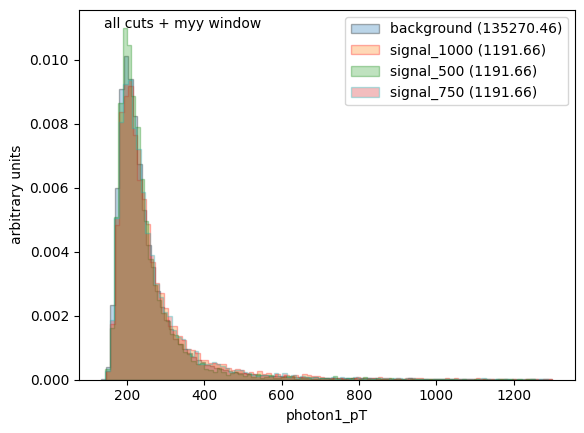

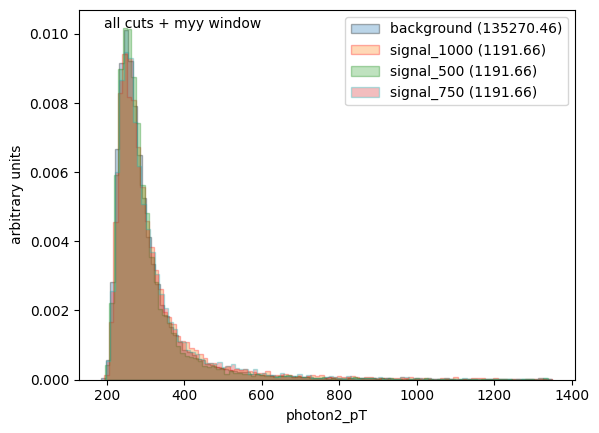

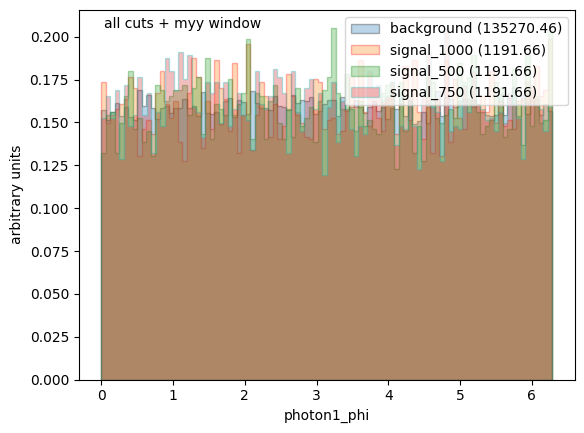

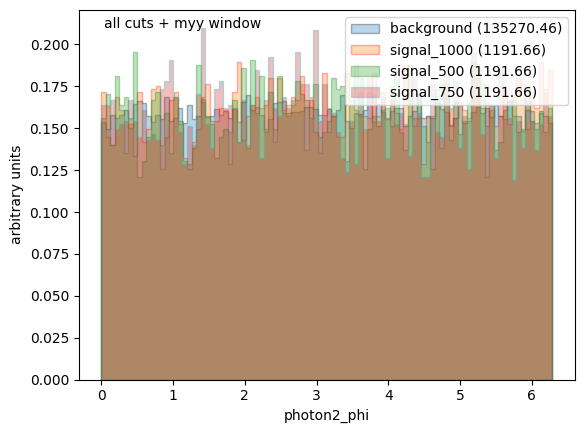

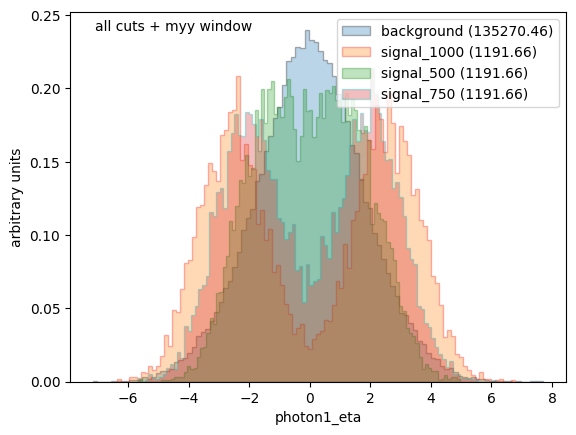

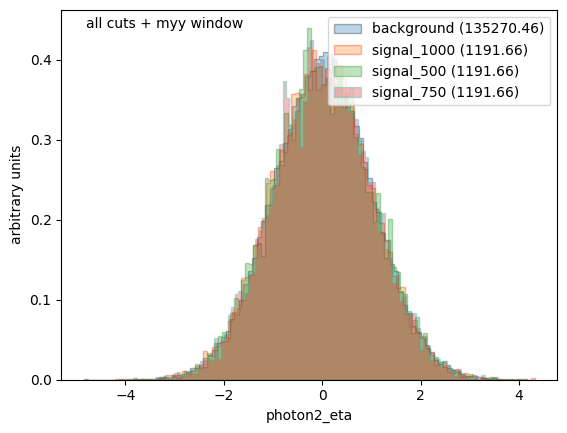

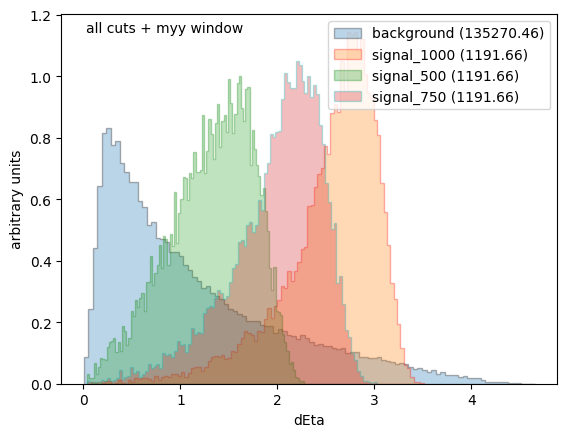

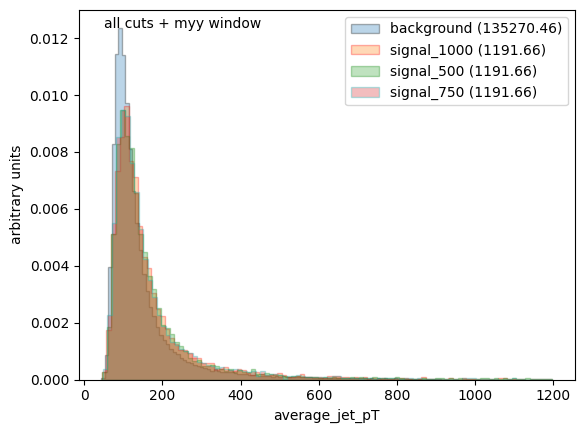

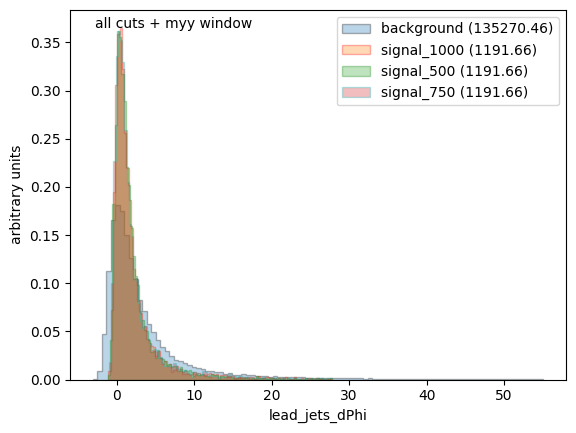

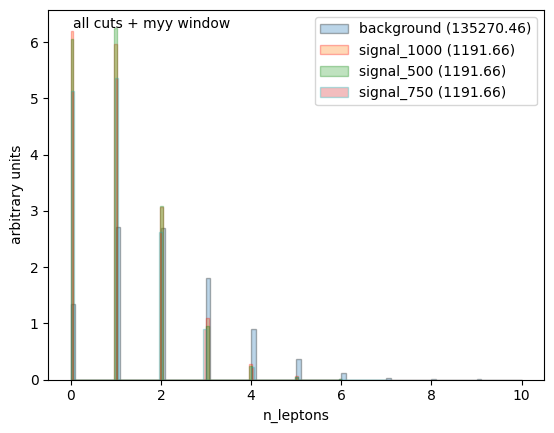

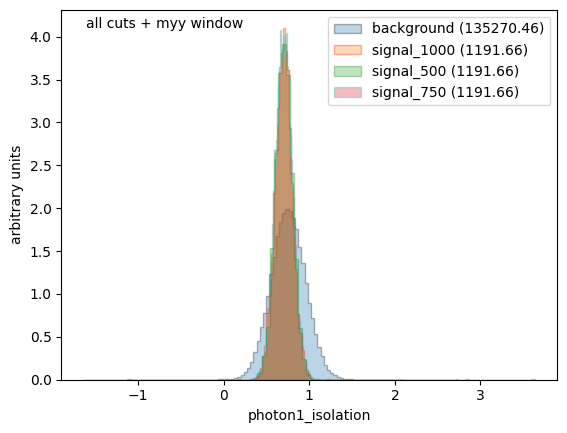

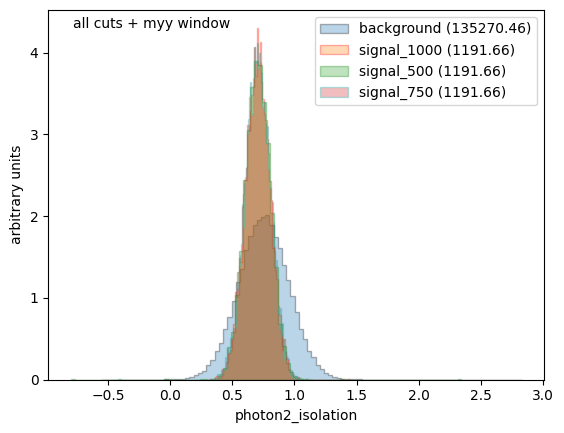

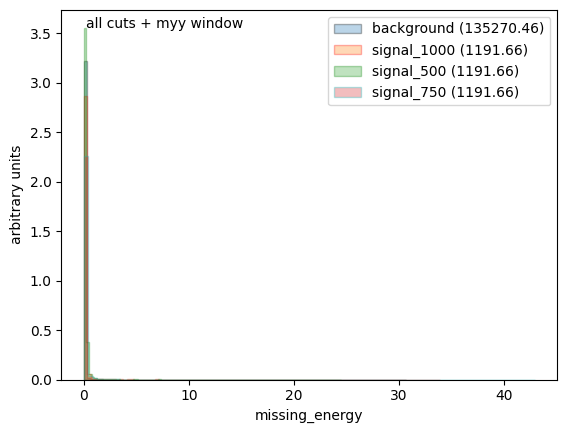

<Figure size 640x480 with 0 Axes>

In [11]:
def redrawAllObs(plotdir, the_cut):
  label = ""
  for obs in observables:
    for i, (s_name, s_data) in enumerate(sorted(sampleDict.items())):
      mask = np.ones(len(s_data[obs])).astype(bool)
      for cut in cutflow["cut"]:
        if cut == "myy window" : continue # skip myy window!
        mask *= masks[s_name][masks["cut"].index(cut)].astype(bool)
        if cut == the_cut : break # stop here !
      data = np.array(s_data[obs][mask])
      plt.hist(data, 100, label = "%s (%.2f)" % (s_name, s_data['weights'][mask].sum()) , alpha=0.3, density=1, edgecolor = edgecolors[i] , histtype='stepfilled')
    plt.legend()
    plt.annotate("all cuts + " + cut, xy=(0.05, 0.95), xycoords='axes fraction')
    plt.ylabel("arbitrary units")
    plt.xlabel(obs)
    plt.show()
    plt.clf()

redrawAllObs(plotdir+"/task1", masks["cut"][-1])



In [12]:
cf_df = pd.DataFrame(cutflow)
cf_df.head()

cut  background  signal_1000  signal_500  signal_750
0        none   135270.46      1191.66     1191.66     1191.66
1  myy window    46445.11      1190.58     1191.30     1191.66

## task 2
 Z is a good figure of merit because sqrt(B) is proportional to the stat error on the background. So Z is just
 telling us how large the signal would be with respect to the uncertainties on the background.
 there may be other multiplicative factors but the maximum S/sqrtB is likely to also be the point of maximum sensitivity since
 multiplicative factors do not change the location of the maximum.

In [13]:
def recalc_Zscores(cf_df):

  Z_av = np.zeros(len(cf_df["background"]))
  Z_n = 0
  for sample_name in sorted(sampleDict.keys()):
       if not "signal" in sample_name: continue
       res = cf_df[sample_name] / ( cf_df["background"]**0.5)
       res[~np.isfinite(res)] = 0
       cf_df["Z-%s" % sample_name] = res
       Z_av  += cf_df["Z-%s" % sample_name]
       Z_n += 1

  cf_df["Z-average"] = Z_av / Z_n



In [14]:
recalc_Zscores(cf_df)
cf_df

cut  background  signal_1000  signal_500  signal_750  Z-signal_1000  \
0        none   135270.46      1191.66     1191.66     1191.66           3.24   
1  myy window    46445.11      1190.58     1191.30     1191.66           5.52   

   Z-signal_500  Z-signal_750  Z-average  
0          3.24          3.24       3.24  
1          5.53          5.53       5.53

# task 3
 looking visually at photon1_isolation, seems like we can ask that it is greater than 0.2 and less than 0.6 without significantly touching the signal

In [15]:
def redraw_myy(plotdir, the_cut):

  for obs in ["myy"]:
    for i, (s_name, s_data) in enumerate(sorted(sampleDict.items())):
      #data = np.array(s_data[obs])
      mask = np.ones(len(s_data)).astype(bool)
      for cut in cutflow["cut"]:
        if cut == "myy window" : continue # skip myy window!
        mask *= masks[s_name][masks["cut"].index(cut)].astype(bool)
        if cut == the_cut : break # skip myy window!
      data = np.array(s_data[obs][mask])
      n, bins, _ = plt.hist(data, binning, label = s_name, alpha=0.3,  histtype='stepfilled', color=edgecolors[i], weights=lumi*cross_sections_times_filter_eff_by_total_N[s_name]*np.ones(len(data)))
      mid = 0.5*(bins[1:] + bins[:-1])
      lab_stat = None
      lab_syst = None
      if i==0 :
        lab_stat = "Stat Errs"
        lab_syst = "Syst Errs"
      plt.errorbar(mid, n, yerr=n**0.5, fmt='none', label=lab_stat, color=edgecolors[i])
      plt.fill_between(mid, n*0.9, n*1.1, color=edgecolors[i], alpha=0.2, label= lab_syst)
      plt.annotate("all cuts + " + cut, xy=(0.05, 0.95), xycoords='axes fraction')

    plt.legend()
    plt.ylabel("arbitrary units")
    plt.xlabel(obs)
    plt.show()
    plt.clf()


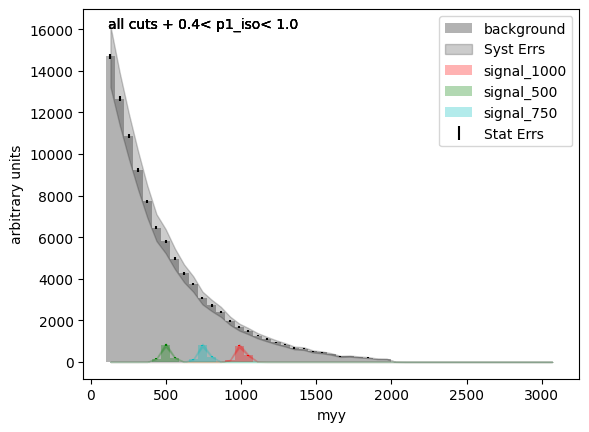

cut  background  signal_1000  signal_500  signal_750  \
0              none   135270.46      1191.66     1191.66     1191.66   
1        myy window    46445.11      1190.58     1191.30     1191.66   
2  0.4< p1_iso< 1.0   135270.46      1191.66     1191.66     1191.66   

   Z-signal_1000  Z-signal_500  Z-signal_750  Z-average  
0           3.24          3.24          3.24       3.24  
1           5.52          5.53          5.53       5.53  
2           3.24          3.24          3.24       3.24

<Figure size 640x480 with 0 Axes>

In [16]:
cutflow["cut"].append("0.4< p1_iso< 1.0")
masks["cut"].append("0.4< p1_iso< 1.0")
for sample_name in sorted(sampleDict.keys()):
  ds = sampleDict[sample_name]


  mask = sampleDict[sample_name]["photon1_isolation"] > 0.4
  mask *= sampleDict[sample_name]["photon1_isolation"] < 1.0

  cumul_mask = np.ones(len(ds))
  for cut_i in range(0, len(masks[sample_name])):
        cumul_mask *= masks[sample_name][cut_i]

  cutflow[sample_name].append(sum(sampleDict[sample_name]["weights"][mask*cumul_mask]))
  masks[sample_name].append(mask)


#redrawAllObs(plotdir+"/task3", masks["cut"][-1])
redraw_myy(plotdir+"/task3", masks["cut"][-1])
cf_df = pd.DataFrame(cutflow)
recalc_Zscores(cf_df)
cf_df.head()

# task 4
try to optimise i the photon1_iso cut

In [17]:
tmp_cutflow = copy.deepcopy(cutflow)

for c_low in np.linspace(0, 1.5, 15):
  for c_high in np.linspace(0, 1.5, 15):
    cutname = "%.2f< p1_iso< %.2f" % (c_low, c_high)
    tmp_cutflow["cut"].append(cutname)
    for sample_name in sorted(sampleDict.keys()):
      ds = sampleDict[sample_name]
      mask = masks[sample_name][masks["cut"].index("myy window")].copy()
      mask *= sampleDict[sample_name]["photon1_isolation"] > c_low
      mask *= sampleDict[sample_name]["photon1_isolation"] < c_high
      tmp_cutflow[sample_name].append(sum(sampleDict[sample_name]["weights"][mask]))
      #print(sample_name, cutname,mask.sum())

cf_df = pd.DataFrame(tmp_cutflow)
recalc_Zscores(cf_df)
cf_df.sort_values(by=["Z-average"], ascending=False).head()





cut  background  signal_1000  signal_500  signal_750  \
86  0.54< p1_iso< 0.86    26178.89      1063.55     1067.01     1063.79   
71  0.43< p1_iso< 0.86    30155.84      1124.33     1118.13     1120.75   
56  0.32< p1_iso< 0.86    32011.75      1127.31     1121.35     1126.11   
41  0.21< p1_iso< 0.86    32547.42      1127.31     1121.47     1126.23   
26  0.11< p1_iso< 0.86    32693.52      1127.31     1121.59     1126.23   

    Z-signal_1000  Z-signal_500  Z-signal_750  Z-average  
86           6.57          6.59          6.57       6.58  
71           6.47          6.44          6.45       6.46  
56           6.30          6.27          6.29       6.29  
41           6.25          6.22          6.24       6.24  
26           6.23          6.20          6.23       6.22

In [18]:
print("==select 0.54 < pt1_iso < 0.86==")

==select 0.54 < pt1_iso < 0.86==


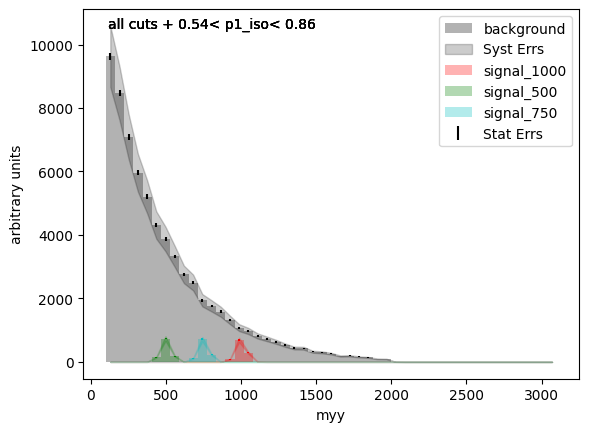

cut  background  signal_1000  signal_500  signal_750  \
0                none   135270.46      1191.66     1191.66     1191.66   
1          myy window    46445.11      1190.58     1191.30     1191.66   
2  0.54< p1_iso< 0.86    26165.36      1063.79     1065.94     1062.96   

   Z-signal_1000  Z-signal_500  Z-signal_750  Z-average  
0           3.24          3.24          3.24       3.24  
1           5.52          5.53          5.53       5.53  
2           6.58          6.59          6.57       6.58

<Figure size 640x480 with 0 Axes>

In [19]:
# identify best cut as 0.54 < pt1_iso < 0.86



cutflow["cut"][-1]="0.54< p1_iso< 0.86"
masks["cut"][-1]="0.54< p1_iso< 0.86"
for sample_name in sorted(sampleDict.keys()):
  ds = sampleDict[sample_name]

  mask_myy = masks[sample_name][masks["cut"].index("myy window")].copy()
  mask = sampleDict[sample_name]["photon1_isolation"] > 0.54
  mask *= sampleDict[sample_name]["photon1_isolation"] < 0.86

  cutflow[sample_name][-1] = sum(sampleDict[sample_name]["weights"][mask*mask_myy])
  masks[sample_name][-1] = mask

cutflow


#redrawAllObs(plotdir+"/task4", masks["cut"][-1])
redraw_myy(plotdir+"/task4", masks["cut"][-1])
cf_df = pd.DataFrame(cutflow)
recalc_Zscores(cf_df)
cf_df.head()

# task 5
try to optimise all cuts

In [20]:
observables_to_optimise = ["photon1_isolation", "photon2_isolation", "n_jets", "average_jet_pT", "lead_jets_dPhi", "n_leptons", "missing_energy"]

def removeColumnsFromCutflow(cutflow, starting_cut):
  tmp_cutflow = copy.deepcopy(cutflow)
  starting_cut_index = cutflow["cut"].index(starting_cut)
  for k in tmp_cutflow.keys():
    for icf in range( starting_cut_index+1, len (cutflow["cut"])) :
      tmp_cutflow[k].pop(-1)
  return tmp_cutflow

In [21]:
def optimise_cut(variable, starting_cut, aboveOrBelow):
  tmp_cutflow = copy.deepcopy(cutflow)
  tmp_cutflow = removeColumnsFromCutflow(tmp_cutflow, starting_cut)
  tmp_masks = {}
  for c_level in np.linspace(min(sampleDict["background"][variable]), 0.99*max(sampleDict["background"][variable]), 50 ):
    cutname = "%s %s %.2f" % (variable, aboveOrBelow, c_level)
    tmp_cutflow["cut"].append(cutname)
    for sample_name in sorted(sampleDict.keys()):
      ds = sampleDict[sample_name]
      cumul_mask = np.ones(len(ds)).astype(bool)
      for cut in tmp_cutflow["cut"]:
        cumul_mask *= masks[sample_name][masks['cut'].index(cut)].astype(bool)
        if cut ==starting_cut : break
      if aboveOrBelow==">":
        mask = sampleDict[sample_name][variable] > c_level
      elif aboveOrBelow=="<":
        mask = sampleDict[sample_name][variable] < c_level
      else:
        print("[ERROR] can't understand aboveOrBelow=", aboveOrBelow)
      tmp_cutflow[sample_name].append(sum(sampleDict[sample_name]["weights"][mask*cumul_mask]))
  cf_df = pd.DataFrame(tmp_cutflow)
  recalc_Zscores(cf_df)
  #print(cf_df.sort_values(by=["Z-average"], ascending=False).head())
  cutname = np.array(cf_df.sort_values(by=["Z-average"], ascending=False)["cut"])[0]#).split("aboveOrBelow")[-1)])
  if variable not in cutname:
    return None, None
  cutval = float(cutname.split(aboveOrBelow)[-1])
  return cutname, cutval

In [22]:
def add_cut(cutflow, variable, aboveOrBelow, value, cutname):
  for sample_name in sorted(sampleDict.keys()):
    ds = sampleDict[sample_name]

    if aboveOrBelow ==">" :
      mask = sampleDict[sample_name][variable] > value
    elif aboveOrBelow=="<":
      mask = sampleDict[sample_name][variable] < value
    else:
      print("[ERROR] can't understand aboveOrBelow=", aboveOrBelow)
    cumul_mask = np.ones(len(ds)).astype(bool)
    for cut in cutflow["cut"]:
          cumul_mask *= masks[sample_name][masks["cut"].index(cut)].astype(bool)
          #print (sample_name, "adding in ", masks["cut"][cut_i], "passing", masks[sample_name][cut_i].sum(), "(", sampleDict[sample_name]["weights"][masks[sample_name][cut_i]].sum(),")", "cumul", cumul_mask.sum(), ")", sampleDict[sample_name]["weights"][cumul_mask].sum(),")" )

    cutflow[sample_name].append(sum(sampleDict[sample_name]["weights"][mask*cumul_mask]))
    masks[sample_name].append(mask)
  cutflow["cut"].append(cutname)
  masks["cut"].append(cutname)
  return cutflow

In [23]:
for oto in observables_to_optimise:
  for aboveOrBelow in [">", "<"]:
    print("Optimising ", oto, aboveOrBelow)
    cutname, cutval = optimise_cut(oto, "myy window", aboveOrBelow)
    #cutname, cutval = optimise_cut(oto, cutflow['cut'][-1], aboveOrBelow)
    print("Optimising ", oto, aboveOrBelow,  cutval)
    if cutname is None: continue
    cutflow = add_cut(cutflow, oto, aboveOrBelow, cutval, cutname)

cf_df = pd.DataFrame(cutflow)
recalc_Zscores(cf_df)


Optimising  photon1_isolation >
Optimising  photon1_isolation > 0.49
Optimising  photon1_isolation <
Optimising  photon1_isolation < 0.87
Optimising  photon2_isolation >
Optimising  photon2_isolation > 0.47
Optimising  photon2_isolation <
Optimising  photon2_isolation < 0.88
Optimising  n_jets >
Optimising  n_jets > None
Optimising  n_jets <
Optimising  n_jets < 3.94
Optimising  average_jet_pT >
Optimising  average_jet_pT > 43.36
Optimising  average_jet_pT <
Optimising  average_jet_pT < None
Optimising  lead_jets_dPhi >
Optimising  lead_jets_dPhi > -0.77
Optimising  lead_jets_dPhi <
Optimising  lead_jets_dPhi < 6.29
Optimising  n_leptons >
Optimising  n_leptons > None
Optimising  n_leptons <
Optimising  n_leptons < 1.41
Optimising  missing_energy >
Optimising  missing_energy > None
Optimising  missing_energy <
Optimising  missing_energy < None


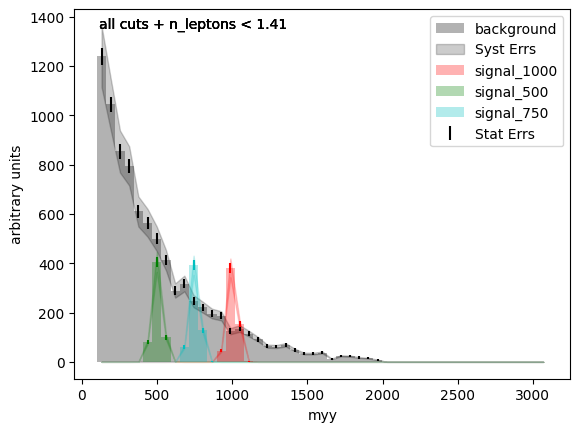

cut  background  signal_1000  signal_500  signal_750  \
0                       none   135270.46      1191.66     1191.66     1191.66   
1                 myy window    46445.11      1190.58     1191.30     1191.66   
2         0.54< p1_iso< 0.86    26165.36      1063.79     1065.94     1062.96   
3   photon1_isolation > 0.49    26165.36      1063.79     1065.94     1062.96   
4   photon1_isolation < 0.87    26165.36      1063.79     1065.94     1062.96   
5   photon2_isolation > 0.47    24109.25      1051.52     1052.83     1048.90   
6   photon2_isolation < 0.88    17349.79      1015.05     1015.53     1007.54   
7              n_jets < 3.94    11171.99       872.65      865.14      867.29   
8     average_jet_pT > 43.36    11171.99       872.65      865.14      867.29   
9     lead_jets_dPhi > -0.77    10012.72       869.67      862.04      864.19   
10     lead_jets_dPhi < 6.29     8082.41       802.46      795.55      791.02   
11          n_leptons < 1.41     3285.72       583.32      586.65      582.72   

    Z-signal_1000  Z-signal_500  Z-signal_750  Z-average  
0            3.24          3.24          3.24       3.24  
1            5.52          5.53          5.53       5.53  
2            6.58          6.59          6.57       6.58  
3            6.58          6.59          6.57       6.58  
4            6.58          6.59          6.57       6.58  
5            6.77          6.78          6.76       6.77  
6            7.71          7.71          7.65       7.69  
7            8.26          8.19          8.21       8.22  
8            8.26          8.19          8.21       8.22  
9            8.69          8.61          8.64       8.65  
10           8.93          8.85          8.80       8.86  
11          10.18         10.23         10.17      10.19

<Figure size 640x480 with 0 Axes>

In [24]:
#redrawAllObs(plotdir+"/task5", cutflow["cut"][-1])
redraw_myy(plotdir+"/task5", cutflow["cut"][-1])
cf_df